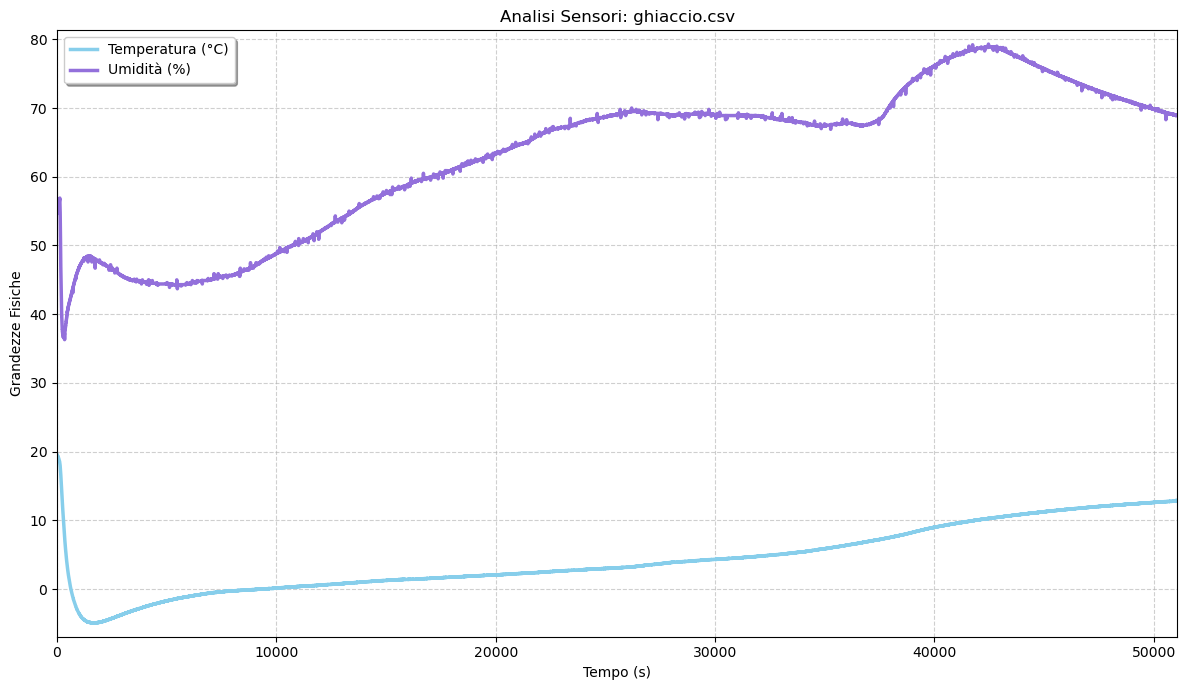

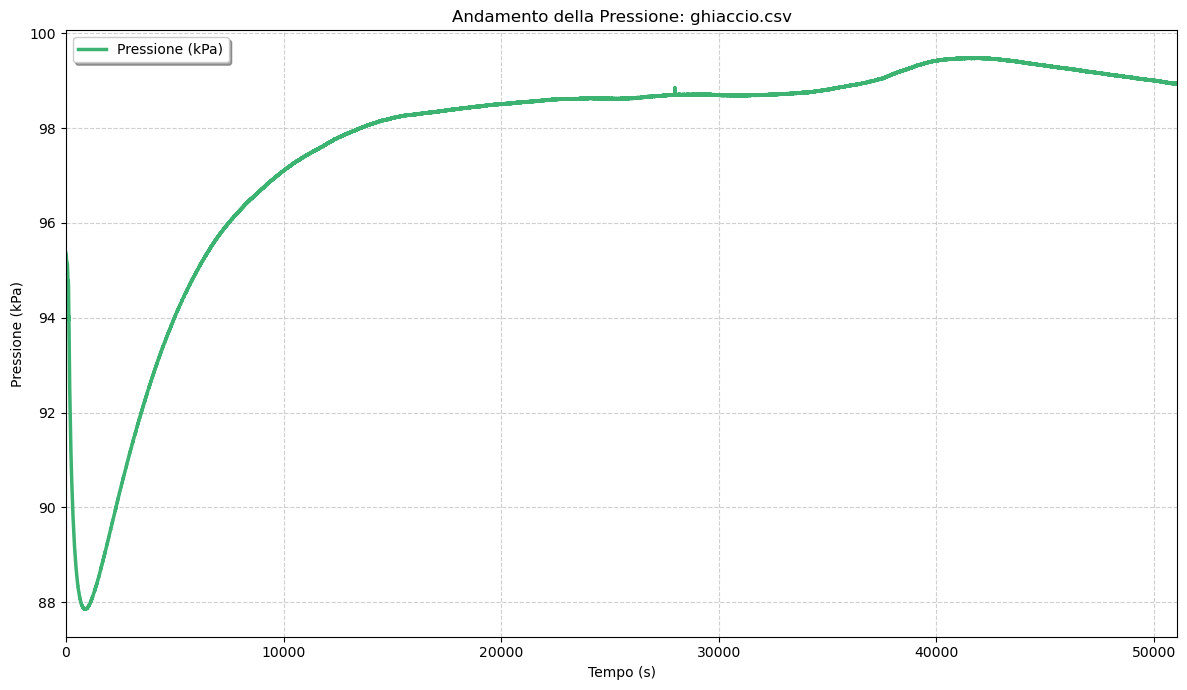

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configurazione Iniziale ---
FOLDER = '300ml'
FILENAME = 'ghiaccio.csv'  # Cambia qui: 'frigo.csv' o 'forno.csv'
FILE_PATH = os.path.join(FOLDER, FILENAME)
STEP_TEMPORALE_S = 1.0  # Definire il passo temporale

# 1. Caricamento Dati
# Assumo che il file esista e sia caricabile, aggiungi header=None se necessario
if os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH)
else:
    raise FileNotFoundError(f"Il file {FILE_PATH} non è stato trovato.")

# 2. Parsing e Pulizia
df.columns = ['Timestamp_Raw', 'Temp_K', 'Hum_Pct', 'Pres_kPa']

regex_num = r'(\d+\.?\d*)' 

df['Temperatura'] = df['Temp_K'].astype(str).str.extract(regex_num).astype(float) - 273.15
df['Umidita'] = df['Hum_Pct'].astype(str).str.extract(regex_num).astype(float)
df['Pressione'] = df['Pres_kPa'].astype(str).str.extract(regex_num).astype(float)
df.dropna(subset=['Temperatura', 'Umidita', 'Pressione'], inplace=True)

# 3. Creazione Asse Temporale Sintetico (Pre-filtraggio)
# Generato prima del taglio per mantenere la coerenza temporale assoluta
df['Tempo_Simulato_s'] = np.arange(len(df)) * STEP_TEMPORALE_S

# --- 3. Plotting: Temperatura e Umidità ---
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(df['Tempo_Simulato_s'], df['Temperatura'], 
         label='Temperatura (°C)', color='skyblue', linewidth=2.5)
ax1.plot(df['Tempo_Simulato_s'], df['Umidita'], 
         label='Umidità (%)', color='mediumpurple', linewidth=2.5)

# Limiti e Label ax1
vals = df[['Temperatura', 'Umidita']].values
if not df.empty:
    y_min, y_max = np.nanmin(vals), np.nanmax(vals)
    ax1.set_ylim(bottom=y_min - 2, top=y_max + 2)
    ax1.set_xlim(left=0, right=df['Tempo_Simulato_s'].max() + STEP_TEMPORALE_S)

ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Grandezze Fisiche')
ax1.set_title(f'Analisi Sensori: {FILENAME}')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

# --- 4. Plotting: Pressione ---
plt.figure(figsize=(12, 7))
plt.plot(df['Tempo_Simulato_s'], df['Pressione'], 
         label='Pressione (kPa)', color='mediumseagreen', linewidth=2.5)

if not df.empty:
    plt.xlim(left=0, right=df['Tempo_Simulato_s'].max() + STEP_TEMPORALE_S)

plt.xlabel('Tempo (s)')
plt.ylabel('Pressione (kPa)')
plt.title(f'Andamento della Pressione: {FILENAME}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()


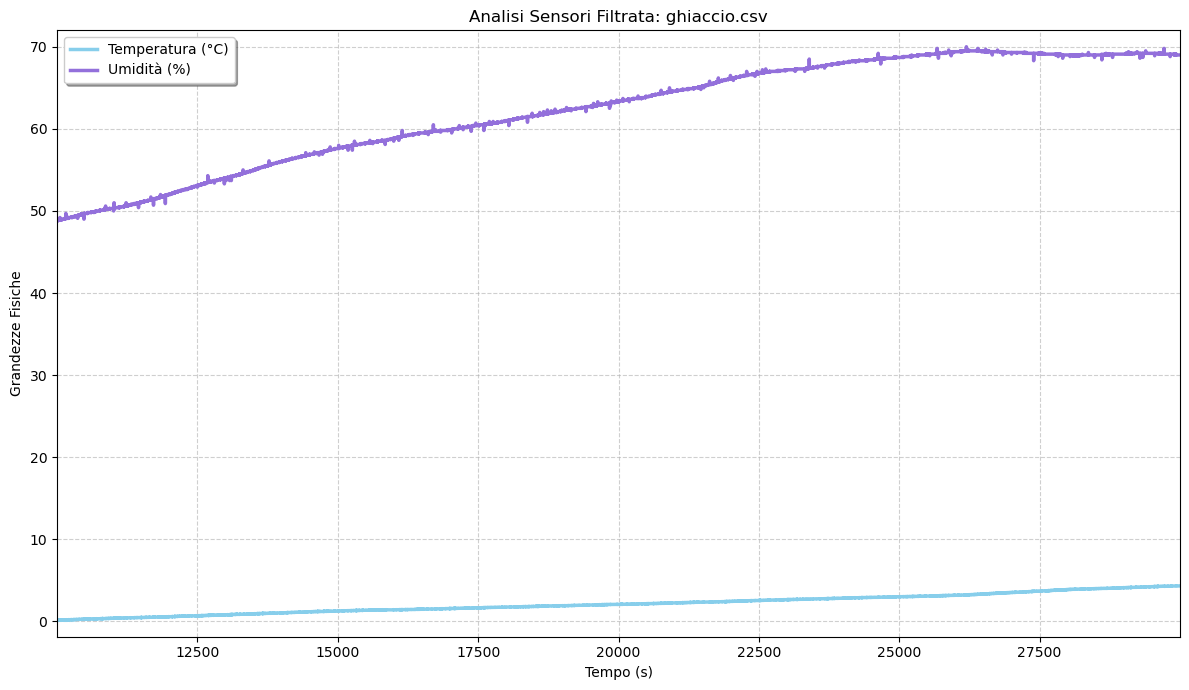

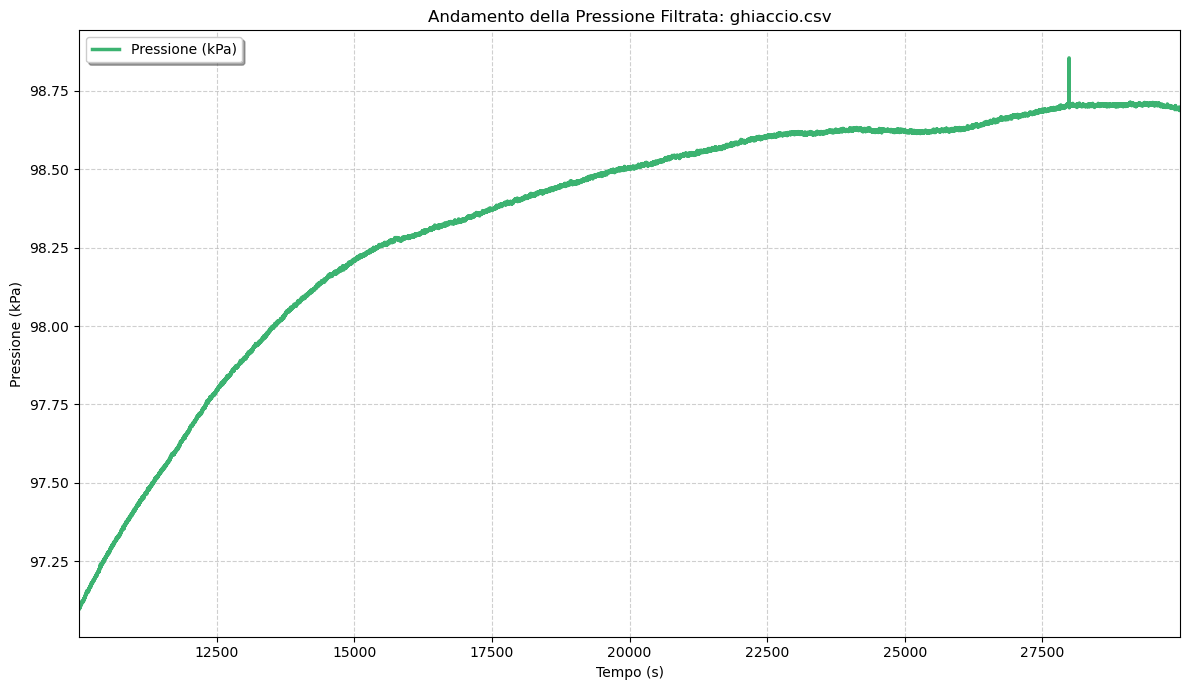

lunghezza finale df dopo filtraggio: 19999


In [137]:

# --- Logica Condizionale per Filtraggio ---
if FILENAME == 'forno.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 2000) | (df['Tempo_Simulato_s'] >= 8000)
    df = df[~mask_to_remove].copy()

elif FILENAME == 'ghiaccio.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 10000) | (df['Tempo_Simulato_s'] >= 30000) 
    df = df[~mask_to_remove].copy()

elif FILENAME == 'frigo.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 1500) | (df['Tempo_Simulato_s'] >= 10000)
    df = df[~mask_to_remove].copy()

elif FILENAME == '24h.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 20000) | \
                     ((df['Tempo_Simulato_s'] >= 50000))
    df = df[~mask_to_remove].copy()

else:
    print("Nessun filtraggio applicato per questo file.")

# --- Plotting Rigenerato con Limiti Aggiornati ---

# 1. Temperatura e Umidità
plt.figure(figsize=(12, 7))
plt.plot(df['Tempo_Simulato_s'], df['Temperatura'],
            label='Temperatura (°C)', color='skyblue', linewidth=2.5)
plt.plot(df['Tempo_Simulato_s'], df['Umidita'], 
            label='Umidità (%)', color='mediumpurple', linewidth=2.5)

# FORZA IL RECALCOLO DEI LIMITI
if not df.empty:
    plt.xlim(df['Tempo_Simulato_s'].min(), df['Tempo_Simulato_s'].max())
    y_min = min(df['Temperatura'].min(), df['Umidita'].min())
    y_max = max(df['Temperatura'].max(), df['Umidita'].max())
    plt.ylim(y_min - 2, y_max + 2)

plt.xlabel('Tempo (s)')
plt.ylabel('Grandezze Fisiche')
plt.title(f'Analisi Sensori Filtrata: {FILENAME}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

# 2. Pressione
plt.figure(figsize=(12, 7))
plt.plot(df['Tempo_Simulato_s'], df['Pressione'],
            label='Pressione (kPa)', color='mediumseagreen', linewidth=2.5)

# FORZA IL RECALCOLO DEI LIMITI
if not df.empty:
    plt.xlim(df['Tempo_Simulato_s'].min(), df['Tempo_Simulato_s'].max())

plt.xlabel('Tempo (s)')
plt.ylabel('Pressione (kPa)')
plt.title(f'Andamento della Pressione Filtrata: {FILENAME}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

print("lunghezza finale df dopo filtraggio:", len(df))

In [138]:
umidity = df['Umidita'].mean()

# --- CONFIGURAZIONE INCERTEZZE ---
u_P_kpa = 0.1     # kPa
u_T_c = 1.0       # °C
u_UR_pct = 4.0    # %
u_V_ml = 3.0      # ml

volume_ml = 322.0 # Volume nominale tolto elettronica 

# --- PREPARAZIONE DATI (SI) ---

p_tot_pa = df['Pressione'] * 1000.0       # kPa -> Pa
t_c_series = df['Temperatura'] 
ur_pct_series = df['Umidita']

# --- DEFINIZIONE LOGICA FISICA (Helper Vettoriale) ---
def core_physics_vectorized(p_pa, t_c, ur_pct, v_ml):
    # 1. Costanti
    Rd = 287.058    # J/kgK (Aria secca)
    Rv = 461.495    # J/kgK (Vapore)
    Md = 0.028964   # kg/mol (Aria secca)
    Mv = 0.018015   # kg/mol (Acqua)
    
    tk = t_c + 273.15       # Ricalcolato qui per seguire le perturbazioni di T
    v_m3 = v_ml * 1e-6 
    
    # Pressioni (Magnus-Tetens)
    # Es: Pressione vapore saturo
    es_hpa = 6.112 * np.exp((17.67 * t_c) / (t_c + 243.5))
    es_pa = es_hpa * 100.0
    
    # Pressione parziale vapore e aria secca
    p_vap = es_pa * (ur_pct / 100.0)
    p_dry = p_pa - p_vap
    
    #  Densità (rho = P / R*T)
    rho_d = p_dry / (Rd * tk)
    rho_v = p_vap / (Rv * tk)
    densita_tot = rho_d + rho_v
    
    # Moli (n = rho * V / MM)
    n_d = (rho_d * v_m3) / Md
    n_v = (rho_v * v_m3) / Mv
    n_tot = n_d + n_v
    
    return n_tot, densita_tot

# ---  CALCOLO NOMINALE ---
n_nominale, rho_nominale = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series, volume_ml)

# ---  PROPAGAZIONE ERRORI (Metodo Numerico) ---

# A. Perturbazione Pressione (Attenzione: u_P in kPa -> convertire in Pa)
n_p, rho_p = core_physics_vectorized(p_tot_pa + (u_P_kpa * 1000.0), t_c_series, ur_pct_series, volume_ml)
dn_dP = n_p - n_nominale
drho_dP = rho_p - rho_nominale

# B. Perturbazione Temperatura
n_t, rho_t = core_physics_vectorized(p_tot_pa, t_c_series + u_T_c, ur_pct_series, volume_ml)
dn_dT = n_t - n_nominale
drho_dT = rho_t - rho_nominale

# C. Perturbazione Umidità
n_ur, rho_ur = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series + u_UR_pct, volume_ml)
dn_dUR = n_ur - n_nominale
drho_dUR = rho_ur - rho_nominale

# D. Perturbazione Volume
n_v, rho_v = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series, volume_ml + u_V_ml)
dn_dV = n_v - n_nominale
drho_dV = rho_v - rho_nominale

# ---  COMBINAZIONE RSS  ---
u_n_tot = np.sqrt(dn_dP**2 + dn_dT**2 + dn_dUR**2 + dn_dV**2)
u_rho_tot = np.sqrt(drho_dP**2 + drho_dT**2 + drho_dUR**2 + drho_dV**2)

# --- SALVATAGGIO RISULTATI ---
# Aggiungiamo direttamente le colonne al dataframe esistente o ne creiamo uno nuovo
df_risultati = pd.DataFrame({
    'Moli': n_nominale,
    'Err_Moli': u_n_tot,
    'Densita': rho_nominale,
    'Err_Densita': u_rho_tot
})

# Visualizza prime righe
print(df_risultati)

           Moli  Err_Moli   Densita  Err_Densita
10001  0.013759  0.000138  1.236206     0.004789
10002  0.013759  0.000138  1.236193     0.004789
10003  0.013760  0.000138  1.236219     0.004789
10004  0.013759  0.000138  1.236193     0.004789
10005  0.013760  0.000138  1.236244     0.004790
...         ...       ...       ...          ...
29995  0.013775  0.000138  1.236301     0.004805
29996  0.013775  0.000138  1.236335     0.004805
29997  0.013775  0.000138  1.236335     0.004805
29998  0.013775  0.000138  1.236352     0.004805
29999  0.013775  0.000138  1.236377     0.004806

[19999 rows x 4 columns]


In [139]:
# media pesata delle moli e densità con le loro incertezze
moli_media = np.average(df_risultati['Moli'], weights=1/df_risultati['Err_Moli']**2)
densita_media = np.average(df_risultati['Densita'], weights=1/df_risultati['Err_Densita']**2)    

err_moli =np.sqrt(1/np.sum(1/df_risultati['Err_Moli']**2))
err_densita =np.sqrt(1/np.sum(1/df_risultati['Err_Densita']**2))

print(f"Moli medie pesate: {moli_media} ± {err_moli}")
print(f"Densità medie pesate: {densita_media} ± {err_densita}")


Moli medie pesate: 0.013834638394305515 ± 9.8284927062716e-07
Densità medie pesate: 1.242284075252463 ± 3.411423114053932e-05


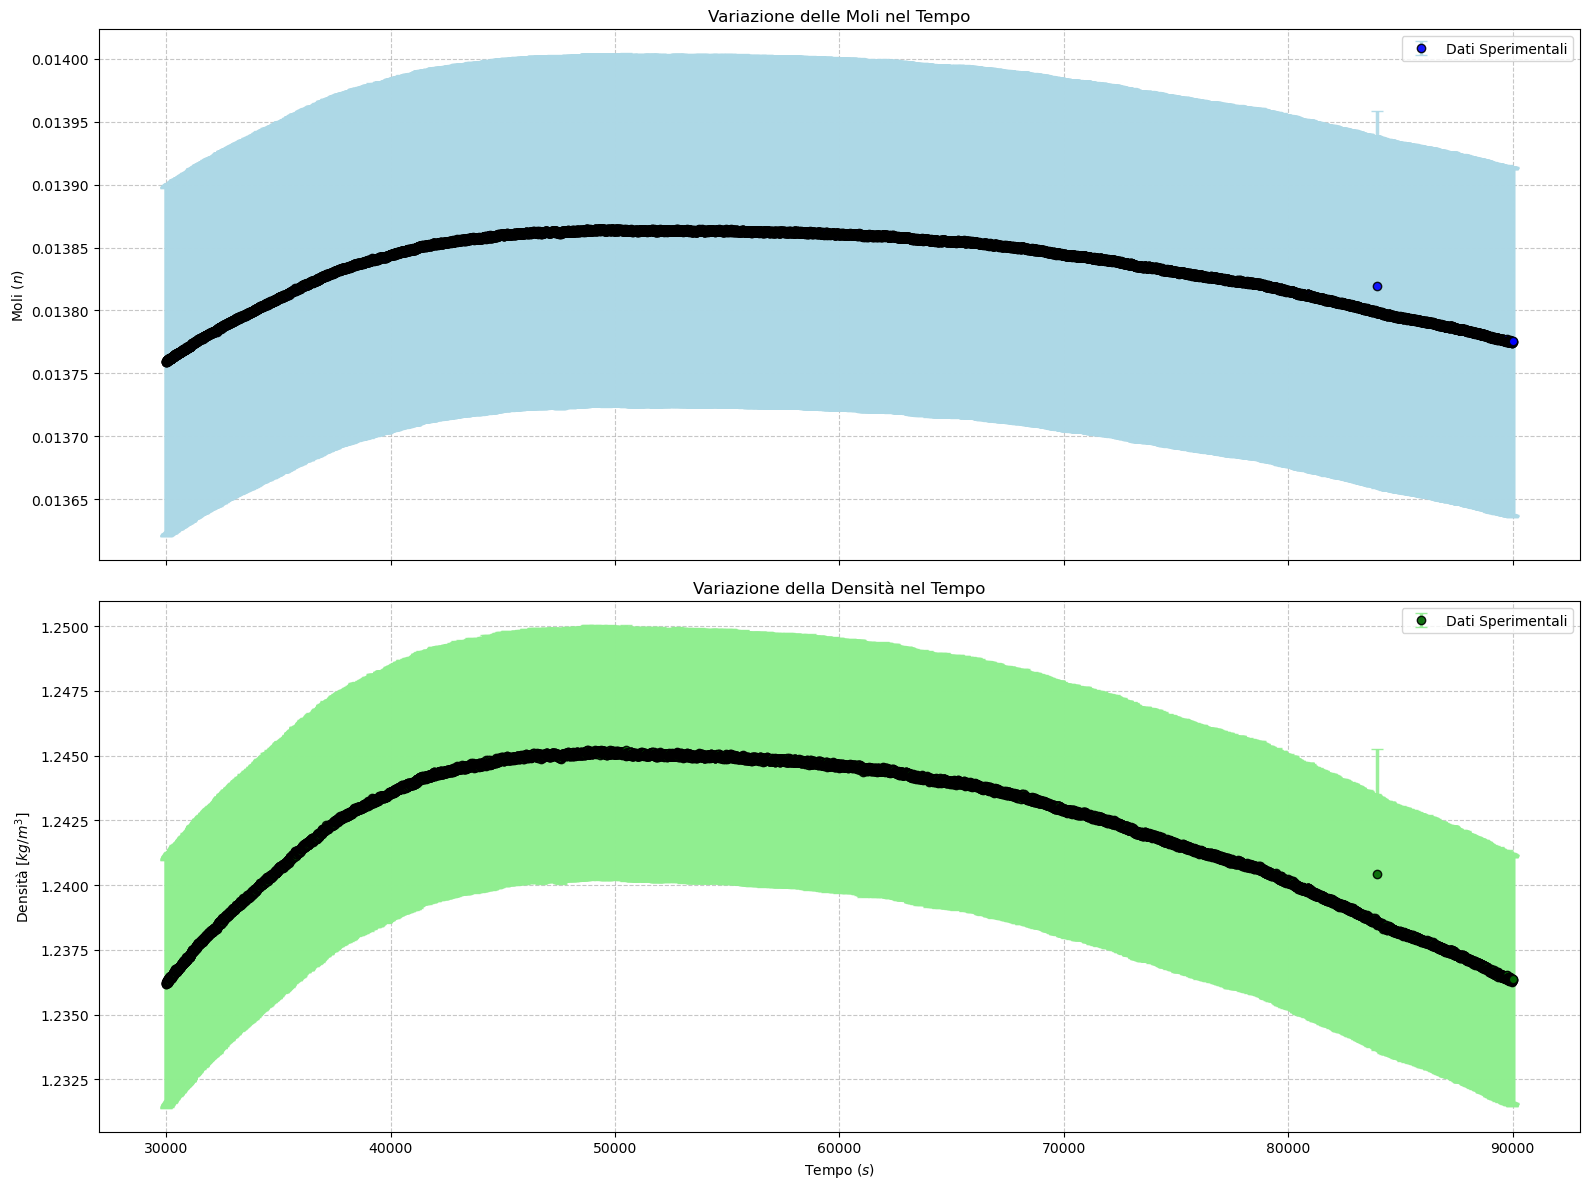

In [140]:
#faccio ora unisogramma delle moli e uno della densità

# Configurazione layout: 2 righe, 1 colonna, dimensioni aumentate (larghezza e altezza)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Asse temporale
t = df_risultati.index * 3

# --- Grafico 1: Moli ---
# ecolor: colore barra errore (più chiaro), color: colore punto (più scuro)
ax1.errorbar(t, df_risultati['Moli'], 
             yerr=df_risultati['Err_Moli'], 
             fmt='o', markersize=6, markerfacecolor='blue', markeredgecolor='black', # Stile Punto
             ecolor='lightblue', elinewidth=2.5, capsize=4, alpha=0.9,               # Stile Errore
             label='Dati Sperimentali')

ax1.set_ylabel(r'Moli ($n$)')
ax1.set_title(r'Variazione delle Moli nel Tempo')
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper right')

# --- Grafico 2: Densità ---
ax2.errorbar(t, df_risultati['Densita'], 
             yerr=df_risultati['Err_Densita'], 
             fmt='o', markersize=6, markerfacecolor='darkgreen', markeredgecolor='black',
             ecolor='lightgreen', elinewidth=2.5, capsize=4, alpha=0.9,
             label='Dati Sperimentali')

ax2.set_xlabel(r'Tempo ($s$)')
ax2.set_ylabel(r'Densità [$kg/m^3$]')
ax2.set_title(r'Variazione della Densità nel Tempo')
ax2.grid(True, which='both', linestyle='--', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

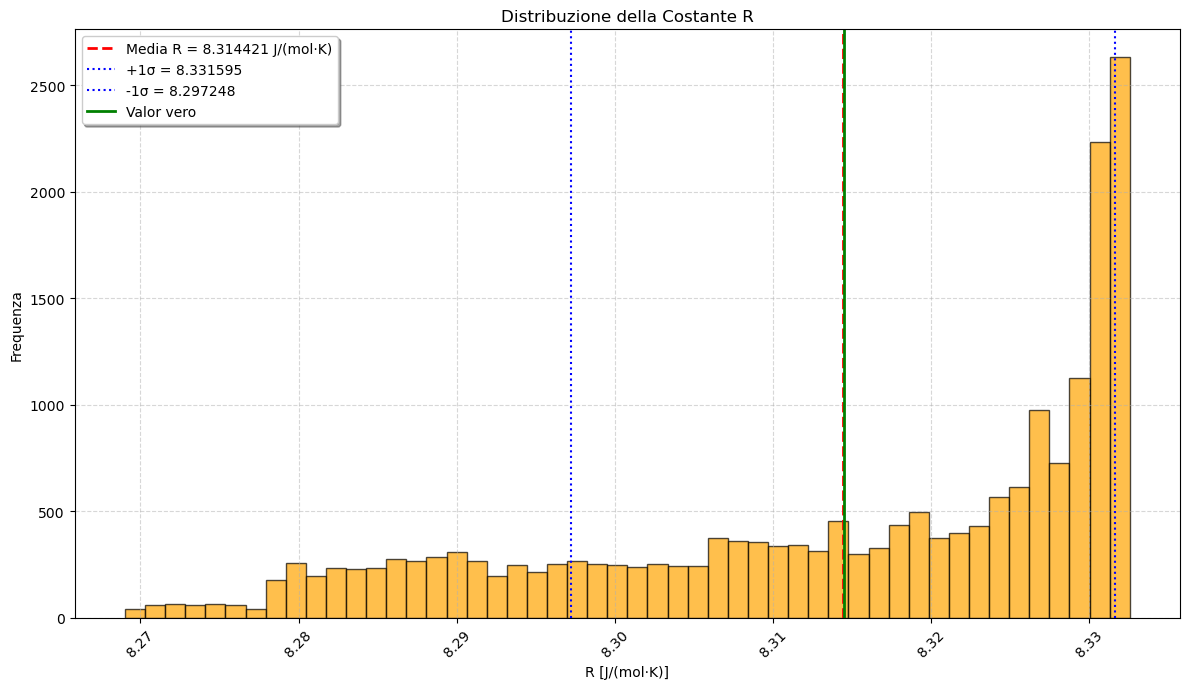

Valore medio calcolato: 8.31442144
Deviazione standard: 1.71734849e-02


In [141]:
# Assicuriamoci che siano nelle stesse unità di misura usate nel calcolo di R
sigma_P_pa = u_P_kpa * 1000.0
sigma_V_m3 = u_V_ml * 1e-6
sigma_T_k  = u_T_c 
sigma_n    = err_moli

P = df['Pressione'] * 1000.0
V = volume_ml * 1e-6
n = moli_media
T = df['Temperatura'] + 273.15

# R calcolato
R = (P * V) / (n * T)

# 3. Calcolo dell'errore associato ad ogni istanza di R (Propagazione)
# Usiamo la formula delle derivate prime (quadratica per variabili indipendenti)
err_R = R * np.sqrt(
    (sigma_P_pa / P)**2 +
    (sigma_V_m3 / V)**2 +
    (sigma_n / n)**2 +
    (sigma_T_k / T)**2
)

# 4. Aggiornamento DataFrame
df_R = pd.DataFrame({
    'R': R,
    'Err_R': err_R
})

# 3. Statistiche
mean_R = df_R['R'].mean()
std_R = df_R['R'].std()

# 4. Plotting
plt.figure(figsize=(12, 7))
plt.hist(df_R['R'], bins=50, color='orange', edgecolor='black', alpha=0.7)

# Linee statistiche con alta precisione nei label
plt.axvline(mean_R, color='red', linestyle='dashed', linewidth=2, 
            label=f'Media R = {mean_R:.6f} J/(mol·K)')
plt.axvline(mean_R + std_R, color='blue', linestyle='dotted', linewidth=1.5, 
            label=f'+1σ = {mean_R + std_R:.6f}')
plt.axvline(mean_R - std_R, color='blue', linestyle='dotted', linewidth=1.5, 
            label=f'-1σ = {mean_R - std_R:.6f}')
plt.axvline(8.3144621, color='green', linestyle='solid', linewidth=2, 
            label='Valor vero')

# --- FIX ASSE X (Rimuove l'offset 1e-7 + 8.314...) ---
ax = plt.gca()

import matplotlib.ticker as ticker

# Forza la visualizzazione dei valori assoluti senza offset
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# Specifica il numero di decimali da mostrare per apprezzare la dispersione
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.title('Distribuzione della Costante R')
plt.xlabel('R [J/(mol·K)]')
plt.ylabel('Frequenza')
plt.xticks(rotation=45) # Ruota per evitare sovrapposizioni date dall'alta precisione
plt.legend(loc='best', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Valore medio calcolato: {mean_R:.8f}")
print(f"Deviazione standard: {std_R:.8e}")


In [142]:
#media pesata degli R
weights = 1 / (df_R['Err_R'] ** 2)
weighted_mean_R = np.sum(df_R['R'] * weights) / np.sum(weights)
weighted_std_R = np.sqrt(1 / np.sum(weights))   
print(f"Media pesata di R: {weighted_mean_R:.8f} ± {weighted_std_R:.8e} J/(mol·K)")

Media pesata di R: 8.31434551 ± 5.90967181e-04 J/(mol·K)


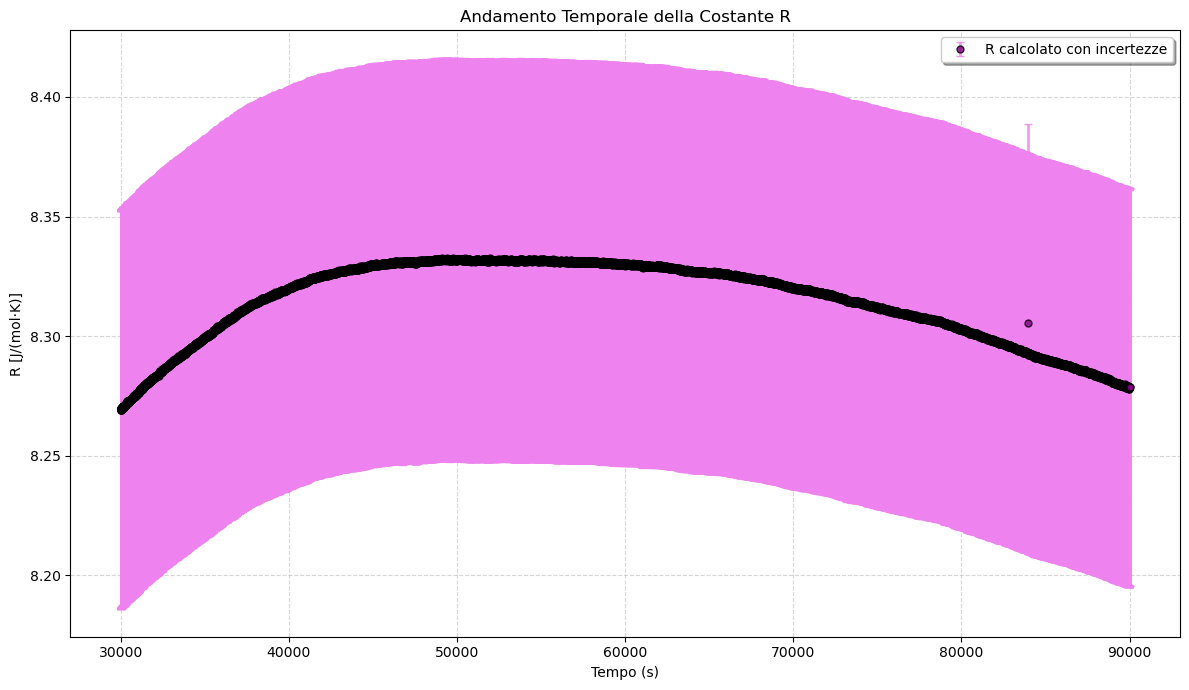

In [143]:
#plot di R con barre d'errore nel tempo
plt.figure(figsize=(12, 7))
plt.errorbar(df_R.index * 3, df_R['R'], 
             yerr=df_R['Err_R'], 
             fmt='o', markersize=5, markerfacecolor='purple', markeredgecolor='black',
             ecolor='violet', elinewidth=2, capsize=3, alpha=0.8,
             label='R calcolato con incertezze')
plt.title(r'Andamento Temporale della Costante R')
plt.xlabel('Tempo (s)')
plt.ylabel('R [J/(mol·K)]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()  

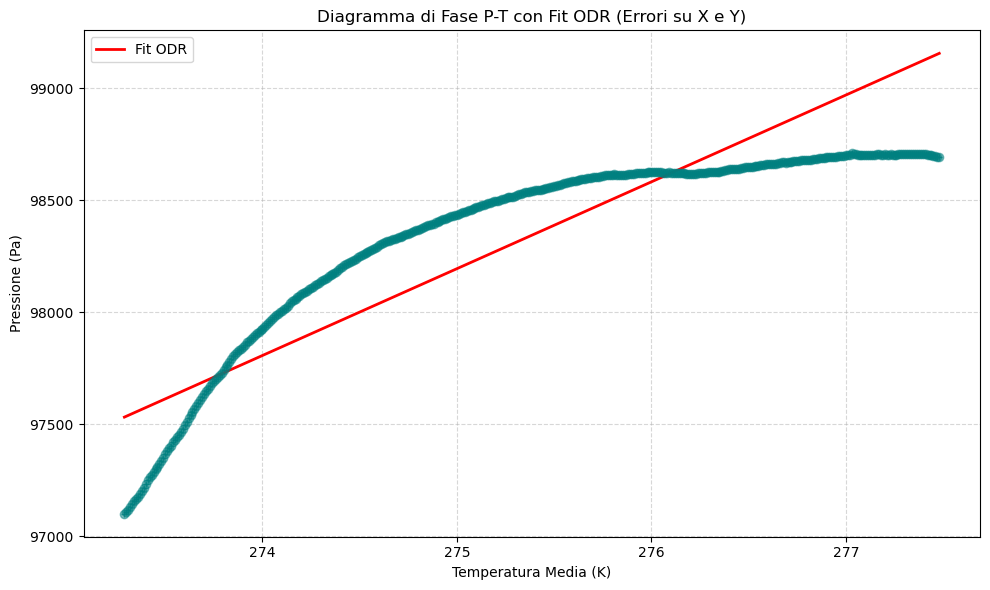

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)   : 387.8526 ± 9.9004 Pa/K
Intercetta Y (q): -8464.7375 ± 2726.4446 Pa
------------------------------
Temperatura allo zero di Pressione:
T(P=0) = 21.82 ± 11.73 K
------------------------------
------------------------------
VERIFICA COMPATIBILITÀ ZERO ASSOLUTO in K
------------------------------
Compatibilità in termini di σ: 1.85 σ


In [144]:
from scipy import odr

# Raggruppo per Temperatura e medio la Pressione
# Nota: Groupby Temperatura riduce il rumore sulla variabile dipendente P
df_PT = df[['Pressione', 'Temperatura']].groupby('Temperatura').mean().reset_index()

# Definisco x (Temp) e y (Press)
x = df_PT['Temperatura'].values + 273.15  # converto in Kelvin per il fit
y = df_PT['Pressione'].values * 1000.0    # kPa -> Pa

# 2. Configurazione ODR (Orthogonal Distance Regression)
# Definisco il modello lineare: y = m*x + q (B[0]=slope, B[1]=intercept)
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])

# Creo l'oggetto RealData con le incertezze costanti
my_data = odr.RealData(x, y, sx=1.0, sy=100)

#inizializo
my_odr = odr.ODR(my_data, linear_model, beta0=[0.1, 90])

# Eseguo il fit
output = my_odr.run()

# Estraggo parametri e incertezze (Deviazione Standard)
m, q = output.beta          # m=pendenza, q=intercetta Y
sm, sq = output.sd_beta     # incertezze su m e q
cov = output.cov_beta       # matrice di covarianza (necessaria per prop. errore)

# 3. Calcolo Temperatura a Pressione 0 (Intercetta asse X)
T0 = -q / m

# Propagazione dell'errore per T0 
deriv_q = -1 / m
deriv_m = q / (m**2)

var_T0 = (deriv_q**2 * output.cov_beta[1, 1] + 
          deriv_m**2 * output.cov_beta[0, 0] + 
          2 * deriv_q * deriv_m * output.cov_beta[0, 1])

sT0 = np.sqrt(var_T0)

# 4. Plotting 
plt.figure(figsize=(10, 6))

# Dati con barre d'errore
# plotto con errori nulli per evidenziare i punti senza barre d'errore
# coloro i punti con una plasma bar per indicare l'evolvere del tempo

plt.errorbar(x, y, xerr=0, yerr=0, fmt='o',  
             color='teal', ecolor='teal', alpha=0.5, capsize=2) 


# Retta di fit
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fit ODR')

plt.title('Diagramma di Fase P-T con Fit ODR (Errori su X e Y)')
plt.ylabel('Pressione (Pa)')
plt.xlabel('Temperatura Media (K)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Risultati
print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)   : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Temperatura allo zero di Pressione:")
print(f"T(P=0) = {T0:.2f} ± {sT0:.2f} K")
print("-" * 30)

sigma_syst_T = 1.0  # Gradi Kelvin/Celsius (Accuratezza assoluta)
sT0_total = np.sqrt(sT0**2 + sigma_syst_T**2)

# 6. compatibilità con zero assoluto 
print("-" * 30)
print("VERIFICA COMPATIBILITÀ ZERO ASSOLUTO in K")
print("-" * 30)
zero_assoluto = 0
diff_T0_zero_assoluto = abs(T0 - zero_assoluto)
comp = diff_T0_zero_assoluto / sT0_total
print(f"Compatibilità in termini di σ: {comp:.2f} σ")    
